<a href="https://colab.research.google.com/github/mayank7533/weatherDemo/blob/master/RNN%20model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# -*- coding: utf-8 -*-
"""
Created on Fri Dec 28 19:54:09 2018

@author: Mayan
"""

import tensorflow as tf
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt 
import numpy as np
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau


df=pd.read_csv("https://raw.githubusercontent.com/mayank7533/weatherDemo/master/datasets/cleanMum.csv",parse_dates=[["date","time"]])
target_names=['T','P','U']
train_names=['T','P','U','Po','DD','VV','Td','Ff','cloud_cov','day']

def retVisib(VV):
    if VV=='less than 0.1':
        return 0
    else:
        return VV
    

def formatData():
    global df
    
    WD={'Wind blowing from the north-east':1, 'Calm, no wind':2,
           'Wind blowing from the north':3, 'Wind blowing from the north-west':4,
           'Wind blowing from the north-northeast':5,
           'Wind blowing from the north-northwest':6,
           'Wind blowing from the west-northwest':7,
           'Wind blowing from the west':8, 'Wind blowing from the south':9,
           'Wind blowing from the west-southwest':10,
           'Wind blowing from the east-southeast':11,
           'Wind blowing from the south-east':12, 'Wind blowing from the east':13,
           'Wind blowing from the east-northeast':14,
           'Wind blowing from the south-southeast':15,
           'Wind blowing from the south-southwest':16,'0':0,
           'Wind blowing from the south-west':17, 'variable wind direction':18}
    df["DD"]=df["DD"].fillna('0')
    
    df["day"]=df['date_time'].apply(lambda x:date_to_nth_day(x))

    df=df.set_index('date_time')
    df["DD"]=df["DD"].apply(lambda x:int(WD[x]))
    df["VV"]=df["VV"].apply(lambda x:retVisib(x))
    df["VV"]=df["VV"].fillna(df['VV'].median())
    #df["T"]=df["T"].fillna(df["T"].median())
    df=df[train_names]
    df=df.interpolate(method='linear')
    
    

def date_to_nth_day(date, format='%Y%m%d'):    
    new_year_day = pd.Timestamp(year=date.year, month=1, day=1)
    return (date - new_year_day).days + 1



formatData()


shift_days=1
shift_steps=shift_days*8
df_target=df[target_names].shift(-shift_steps)

x_data=df.values[0:-shift_steps]
y_data=df_target.values[:-shift_steps]

num_data=len(x_data)
train_split=0.9
num_train=int(train_split*num_data)
num_test=num_data-num_train
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
num_x_signals = x_data.shape[1]
num_y_signals = y_data.shape[1]

x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)
print(x_train_scaled.shape)
print(y_train_scaled.shape)
#add day into df

df["DD"].unique()

def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)
        
batch_size = 256
sequence_length=8*7*8
generator = batch_generator(batch_size=batch_size,sequence_length=sequence_length)

x_batch, y_batch = next(generator)

batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

seq = y_batch[batch, :, signal]
plt.plot(seq)
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

model = Sequential()
model.add(GRU(units=512,return_sequences=True,input_shape=(None, num_x_signals,)))
model.add(Dense(num_y_signals, activation='sigmoid'))
warmup_steps = 50




def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculate the MSE loss for each value in these tensors.
    # This outputs a 3-rank tensor of the same shape.
    loss = tf.losses.mean_squared_error(labels=y_true_slice,
                                        predictions=y_pred_slice)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire tensor, we reduce it to a
    # single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

optimizer = RMSprop(lr=1e-3)
model.compile(loss=loss_mse_warmup, optimizer=optimizer)
model.summary()


path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,monitor='val_loss',verbose=1,save_weights_only=True,save_best_only=True)


callback_early_stopping = EarlyStopping(monitor='val_loss',patience=5, verbose=1)


callback_tensorboard = TensorBoard(log_dir='./23_logs/',histogram_freq=0,write_graph=False)

callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)


callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

model.fit_generator(generator=generator,
                    epochs=5,
                    steps_per_epoch=100,
                    validation_data=validation_data,
                    callbacks=callbacks)
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)
    

result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))


print("loss (test-set):", result)

if False:
    for res, metric in zip(result, model.metrics_names):
        print("{0}: {1:.3e}".format(metric, res))
        
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

plot_comparison(start_idx=100000, length=1000, train=True)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


(33707, 10)
(33707, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 512)         803328    
_________________________________________________________________
dense (Dense)                (None, None, 3)           1539      
Total params: 804,867
Trainable params: 804,867
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
 99/100 [============================>.] - ETA: 1s - loss: 0.0085
Epoch 00001: val_loss improved from inf to 0.00614, saving model to 23_checkpoint.keras
100/100 [==============================] - 113s 1s/step - loss: 0.0085 - val_loss: 0.0061
Epoch 2/5
 99/100 [============================>.] - ETA: 1s - loss: 0.0049
Epoch 00002: val_loss improved from 0.00614 to 0.00552, saving model to 23_checkpoint.keras
100/100 [==============================] - 110s 1s/step - loss: 0.0049 - val_loss: 0.00

UnimplementedError: ignored

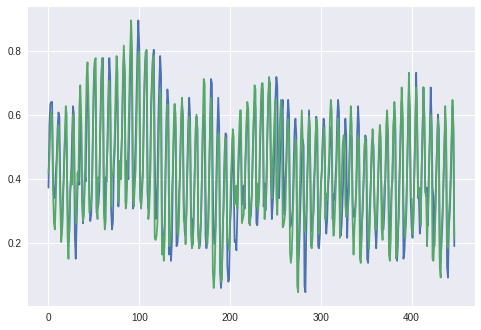

In [0]:
# -*- coding: utf-8 -*-
"""
Created on Fri Dec 28 19:54:09 2018

@author: Mayan
"""

import tensorflow as tf
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt 
import numpy as np
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau


df=pd.read_csv("https://raw.githubusercontent.com/mayank7533/weatherDemo/master/datasets/cleanMum.csv",parse_dates=[["date","time"]])
target_names=['T','P','U']
train_names=['T','P','U','Po','DD','VV','Td','Ff','cloud_cov','day']

def retVisib(VV):
    if VV=='less than 0.1':
        return 0
    else:
        return VV
    

def formatData():
    global df
    
    WD={'Wind blowing from the north-east':1, 'Calm, no wind':2,
           'Wind blowing from the north':3, 'Wind blowing from the north-west':4,
           'Wind blowing from the north-northeast':5,
           'Wind blowing from the north-northwest':6,
           'Wind blowing from the west-northwest':7,
           'Wind blowing from the west':8, 'Wind blowing from the south':9,
           'Wind blowing from the west-southwest':10,
           'Wind blowing from the east-southeast':11,
           'Wind blowing from the south-east':12, 'Wind blowing from the east':13,
           'Wind blowing from the east-northeast':14,
           'Wind blowing from the south-southeast':15,
           'Wind blowing from the south-southwest':16,'0':0,
           'Wind blowing from the south-west':17, 'variable wind direction':18}
    df["DD"]=df["DD"].fillna('0')
    
    df["day"]=df['date_time'].apply(lambda x:date_to_nth_day(x))

    df=df.set_index('date_time')
    df["DD"]=df["DD"].apply(lambda x:int(WD[x]))
    df["VV"]=df["VV"].apply(lambda x:retVisib(x))
    df["VV"]=df["VV"].fillna(df['VV'].median())
    #df["T"]=df["T"].fillna(df["T"].median())
    df=df[train_names]
    df=df.interpolate(method='linear')
    
    

def date_to_nth_day(date, format='%Y%m%d'):    
    new_year_day = pd.Timestamp(year=date.year, month=1, day=1)
    return (date - new_year_day).days + 1



formatData()


shift_days=1
shift_steps=shift_days*8
df_target=df[target_names].shift(-shift_steps)

x_data=df.values[0:-shift_steps]
y_data=df_target.values[:-shift_steps]

num_data=len(x_data)
train_split=0.9
num_train=int(train_split*num_data)
num_test=num_data-num_train
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
num_x_signals = x_data.shape[1]
num_y_signals = y_data.shape[1]

x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)
print(x_train_scaled.shape)
print(y_train_scaled.shape)
#add day into df

df["DD"].unique()

def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)
        
batch_size = 256
sequence_length=8*7*8
generator = batch_generator(batch_size=batch_size,sequence_length=sequence_length)

x_batch, y_batch = next(generator)

batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

seq = y_batch[batch, :, signal]
plt.plot(seq)
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

model = Sequential()
model.add(GRU(units=512,return_sequences=True,input_shape=(None, num_x_signals,)))
model.add(Dense(num_y_signals, activation='sigmoid'))
warmup_steps = 50




def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculate the MSE loss for each value in these tensors.
    # This outputs a 3-rank tensor of the same shape.
    loss = tf.losses.mean_squared_error(labels=y_true_slice,
                                        predictions=y_pred_slice)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire tensor, we reduce it to a
    # single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

optimizer = RMSprop(lr=1e-3)
model.compile(loss=loss_mse_warmup, optimizer=optimizer)
model.summary()


path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,monitor='val_loss',verbose=1,save_weights_only=True,save_best_only=True)


callback_early_stopping = EarlyStopping(monitor='val_loss',patience=5, verbose=1)


callback_tensorboard = TensorBoard(log_dir='./23_logs/',histogram_freq=0,write_graph=False)

callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)


callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

model.fit_generator(generator=generator,
                    epochs=5,
                    steps_per_epoch=100,
                    validation_data=validation_data,
                    callbacks=callbacks)
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)
    

result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))


print("loss (test-set):", result)

if False:
    for res, metric in zip(result, model.metrics_names):
        print("{0}: {1:.3e}".format(metric, res))
        
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

plot_comparison(start_idx=100000, length=1000, train=True)